In [1]:
#  Install libraries (run once)
!pip install -q scikit-learn pandas numpy joblib matplotlib

In [2]:
#  Upload the Unstop CSV (run and choose file)
from google.colab import files
uploaded = files.upload()

Saving 68b1acd44f393_Sample_Support_Emails_Dataset.csv to 68b1acd44f393_Sample_Support_Emails_Dataset.csv


In [6]:
# If upload successful, get filename automatically
import io, sys, os
if len(uploaded) == 0:
    raise SystemExit("File not uploaded....")
fn = list(uploaded.keys())[0]
print("Uploaded file:", fn)

Uploaded file: 68b1acd44f393_Sample_Support_Emails_Dataset.csv


In [7]:
#  Load dataset
import pandas as pd
df = pd.read_csv(fn)
print("Shape:", df.shape)
display(df.head())

Shape: (20, 4)


,sender,subject,body,sent_date
0,eve@startup.io,Help required with account verification,Do you support integration with third-party AP...,19/08/2025 00:58
1,diana@client.co,General query about subscription,"Hi team, I am unable to log into my account si...",25/08/2025 00:58
2,eve@startup.io,Immediate support needed for billing error,"Hello, I wanted to understand the pricing tier...",20/08/2025 12:58
3,alice@example.com,Urgent request: system access blocked,"Hi team, I am unable to log into my account si...",21/08/2025 21:58
4,eve@startup.io,Question: integration with API,"Despite multiple attempts, I cannot reset my p...",20/08/2025 04:58


In [9]:
#  Basic EDA & preprocessing
# Combine subject + body into a single text column
df['subject'] = df['subject'].astype(str)
df['body'] = df['body'].astype(str)
df['text'] = (df['subject'] + " " + df['body']).str.strip()

print("\nColumns:", df.columns.tolist())
print("\nSample text examples:")
for i, row in df.head(6).iterrows():
    print(f"\n--- row {i} ---")
    print(row['text'][:300])




Columns: ['sender', 'subject', 'body', 'sent_date', 'text']

Sample text examples:

--- row 0 ---
Help required with account verification Do you support integration with third-party APIs? Specifically, I’m looking for CRM integration options.

--- row 1 ---
General query about subscription Hi team, I am unable to log into my account since yesterday. Could you please help me resolve this issue?

--- row 2 ---
Immediate support needed for billing error Hello, I wanted to understand the pricing tiers better. Could you share a detailed breakdown?

--- row 3 ---
Urgent request: system access blocked Hi team, I am unable to log into my account since yesterday. Could you please help me resolve this issue?

--- row 4 ---
Question: integration with API Despite multiple attempts, I cannot reset my password. The reset link doesn’t seem to work.

--- row 5 ---
Critical help needed for downtime Hi team, I am unable to log into my account since yesterday. Could you please help me resolve this issue

In [10]:
#  TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english", max_df=0.85, min_df=1, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['text'])
print("\nTF-IDF shape:", X_tfidf.shape)



TF-IDF shape: (20, 180)


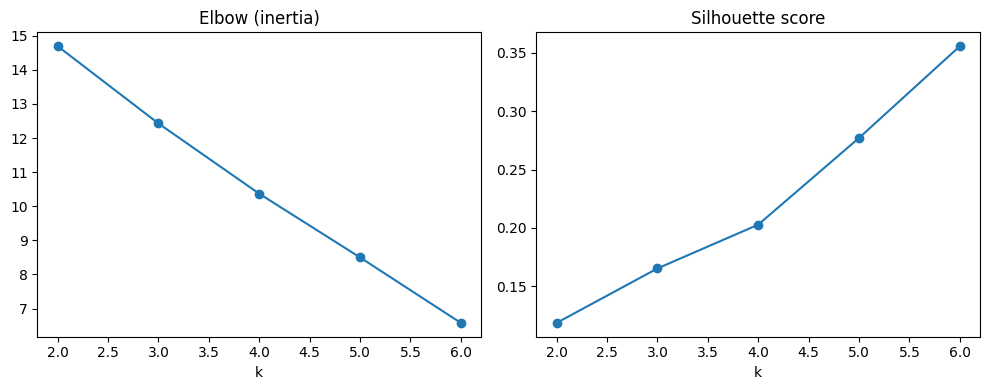

In [11]:
#   Find a good k using silhouette / inertia
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
ks = list(range(2,7))  # 2..6
inertias = []
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_tfidf)
    inertias.append(km.inertia_)
    try:
        sil_scores.append(silhouette_score(X_tfidf, labels))
    except:
        sil_scores.append(float('nan'))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title("Elbow (inertia)")
plt.xlabel("k")
plt.subplot(1,2,2)
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette score")
plt.xlabel("k")
plt.tight_layout()
plt.show()

# Choose k (default 6). If elbow or silhouette suggests others, change k below.
k = 6

In [12]:
#  KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_tfidf)
print("\nCluster counts:")
display(df['cluster'].value_counts().sort_index())


Cluster counts:


,count
cluster,
0,4
1,3
2,4
3,3
4,2
5,4


In [14]:
#  Top terms per cluster -> use cluster centers to find important words
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

topn = 10
cluster_terms = {}
print("\nTop terms per cluster:")
for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :topn]]
    cluster_terms[i] = top_terms
    print(f"Cluster {i}:", ", ".join(top_terms))




Top terms per cluster:
Cluster 0: issue, yesterday help, unable, yesterday, team, team unable, resolve issue, resolve, hi team, log
Cluster 1: critical, servers, support highly, servers need, highly critical, need immediate, highly, need, immediate support, immediate
Cluster 2: reset, work, reset password, reset link, despite multiple, despite, link doesn, link, attempts reset, attempts
Cluster 3: integration, verification support, specifically, specifically looking, integration party, looking crm, integration options, looking, crm integration, crm
Cluster 4: verifying, verification email, verifying account, issues verifying, facing issues, facing, email, email arrived, arrived, arrived assist
Cluster 5: billing, error, billing error, twice needs, charged, immediate correction, needs immediate, error charged, needs, twice


In [15]:
#  Show sample emails per cluster (up to 5)
import textwrap
print("\nSample emails per cluster (up to 5 each):")
for i in range(k):
    print(f"\n--- Cluster {i} (n={len(df[df['cluster']==i])}) ---")
    samples = df[df['cluster']==i]['text'].head(5).tolist()
    if len(samples)==0:
        print(" (no examples)")
    for s in samples:
        print(textwrap.fill(s, width=120))
        print("----")



Sample emails per cluster (up to 5 each):

--- Cluster 0 (n=4) ---
General query about subscription Hi team, I am unable to log into my account since yesterday. Could you please help me
resolve this issue?
----
Urgent request: system access blocked Hi team, I am unable to log into my account since yesterday. Could you please help
me resolve this issue?
----
Critical help needed for downtime Hi team, I am unable to log into my account since yesterday. Could you please help me
resolve this issue?
----
Support needed for login issue Hi team, I am unable to log into my account since yesterday. Could you please help me
resolve this issue?
----

--- Cluster 1 (n=3) ---
General query about subscription Our servers are down, and we need immediate support. This is highly critical.
----
Critical help needed for downtime Our servers are down, and we need immediate support. This is highly critical.
----
Query about product pricing Our servers are down, and we need immediate support. This is highl

In [16]:
# Suggested cluster -> category mapping (change after inspecting top terms)
# These are suggested defaults — change if top terms indicate different meaning.
cluster_map = {
    0: "Billing / Payment",
    1: "Login / Account Verification",
    2: "Downtime / Outage / Critical",
    3: "Integration / API / Feature request",
    4: "General / Pricing / Subscription",
    5: "Password reset / Access issues"
}

df['category'] = df['cluster'].map(cluster_map)

In [17]:
#  Save predictions.csv (sender, subject, body, sent_date, cluster, category)
out_cols = [c for c in ['sender','subject','body','sent_date','cluster','category'] if c in df.columns or c in ['cluster','category']]
df.to_csv("predictions.csv", index=False, columns=out_cols)
print("\nSaved predictions.csv with columns:", out_cols)


Saved predictions.csv with columns: ['sender', 'subject', 'body', 'sent_date', 'cluster', 'category']


In [18]:
#  Save models + vectorizer (so you can run inference later)
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Saved kmeans_model.pkl and tfidf_vectorizer.pkl")

Saved kmeans_model.pkl and tfidf_vectorizer.pkl


In [22]:
#  Save requirements.txt and README.md
with open("requirements.txt","w") as f:
    f.write("pandas\nscikit-learn\nnumpy\njoblib\nmatplotlib\n")
readme_text = f"""
# Support Email Clustering (Unsupervised)

This repo clusters support emails into categories using TF-IDF + KMeans.

## What I did
- Combined `subject` + `body` into `text`
- TF-IDF vectorization
- KMeans clustering (k={k})
- Inspected top terms and sample emails per cluster
- Mapped cluster numbers to human-readable categories

## Files generated
- predictions.csv  (original columns + cluster + category)
- kmeans_model.pkl
- tfidf_vectorizer.pkl
- requirements.txt

## How to run
1. Upload `Sample_Support_Emails_Dataset.csv` to Colab
2. Run the notebook cells in order
3. Download `predictions.csv` and upload to GitHub for submission


"""
with open("README.md","w") as f:
    f.write(readme_text)
print("Saved README.md and requirements.txt")


Saved README.md and requirements.txt


In [23]:
#  Download files to local (useful)
from google.colab import files as gfiles
gfiles.download("predictions.csv")
gfiles.download("README.md")
gfiles.download("requirements.txt")
gfiles.download("kmeans_model.pkl")
gfiles.download("tfidf_vectorizer.pkl")
print("Download prompts started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download prompts started
